# Binary classification
---------------------------------

This example shows how we can use ATOM to perform a variety of data cleaning steps in order to prepare the data for modelling. Then, we compare the performances of two tree-based models.

The data used is a variation on the Australian weather dataset from [https://www.kaggle.com/jsphyg/weather-dataset-rattle-package](https://www.kaggle.com/jsphyg/weather-dataset-rattle-package). The goal of this dataset is to predict whether or not it will rain tomorrow training a binay classifier on target `RainTomorrow`.

## Load the data

In [1]:
# Import packages
import pandas as pd
from atom import ATOMClassifier

In [2]:
# Load data
X = pd.read_csv('./datasets/weatherAUS.csv')

# Let's have a look at a subset of the data
X.sample(frac=1).iloc[:5, :8]

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed
86261,Cairns,21.4,31.7,0.2,9.6,8.4,ESE,35.0
5406,BadgerysCreek,15.0,24.8,0.0,NaN,NaN,E,30.0
38335,WaggaWagga,10.9,29.1,0.2,7.0,9.1,WSW,54.0
60531,Sale,8.0,29.1,0.0,4.4,10.6,ESE,35.0
105879,Woomera,15.0,28.2,0.0,14.2,NaN,S,31.0


## Run the pipeline

In [3]:
# Call ATOM using only 5% of the complete dataset (for explanatory purposes)
atom = ATOMClassifier(X, 'RainTomorrow', n_rows=0.05, n_jobs=8, warnings=False, verbose=2, random_state=1)

<< ================== ATOM ================== >>
Algorithm task: binary classification.
Parallel processing with 8 cores.
Applying data cleaning...

Dataset stats ================= >>
Shape: (7110, 22)
Missing values: 15896
Categorical columns: 5
Scaled: False
----------------------------------
Train set size: 5688
Test set size: 1422
----------------------------------
Train set balance: No:Yes <==> 3.7:1.0
Test set balance: No:Yes <==> 4.1:1.0
----------------------------------
Instances in RainTomorrow per class:
|        |    total |    train_set |    test_set |
|:-------|---------:|-------------:|------------:|
| 0: No  |     5615 |         4473 |        1142 |
| 1: Yes |     1495 |         1215 |         280 |



In [4]:
# Impute missing values
atom.impute(strat_num='knn', strat_cat='drop', min_frac_rows=0.8)

Fitting Imputer...
Imputing missing values...
 --> Dropping 774 rows for containing less than 80% non-missing values.
 --> Imputing 7 missing values using the KNN imputer in feature MinTemp.
 --> Imputing 5 missing values using the KNN imputer in feature MaxTemp.
 --> Imputing 33 missing values using the KNN imputer in feature Rainfall.
 --> Imputing 2315 missing values using the KNN imputer in feature Evaporation.
 --> Imputing 2648 missing values using the KNN imputer in feature Sunshine.
 --> Dropping 202 rows due to missing values in feature WindGustDir.
 --> Dropping 358 rows due to missing values in feature WindDir9am.
 --> Dropping 15 rows due to missing values in feature WindDir3pm.
 --> Imputing 17 missing values using the KNN imputer in feature Humidity9am.
 --> Imputing 54 missing values using the KNN imputer in feature Humidity3pm.
 --> Imputing 37 missing values using the KNN imputer in feature Pressure9am.
 --> Imputing 34 missing values using the KNN imputer in feature P

In [5]:
# Encode the categorical features
atom.encode(strategy='CatBoost', max_onehot=10, frac_to_other=0.04)

Fitting Encoder...
Encoding categorical columns...
 --> CatBoost-encoding feature Location. Contains 1 unique classes.
 --> CatBoost-encoding feature WindGustDir. Contains 16 unique classes.
 --> CatBoost-encoding feature WindDir9am. Contains 16 unique classes.
 --> CatBoost-encoding feature WindDir3pm. Contains 16 unique classes.
 --> Label-encoding feature RainToday. Contains 2 unique classes.


In [6]:
# Perform undersampling of the majority class
atom.balance(strategy='smote', sampling_strategy=0.9)
atom.stats()  # Note the balanced training set

Oversampling with SMOTE...
 --> Adding 2303 rows to category: Yes.

Dataset stats ================= >>
Shape: (8033, 22)
Scaled: False
----------------------------------
Train set size: 6887
Test set size: 1146
----------------------------------
Train set balance: No:Yes <==> 1.1:1.0
Test set balance: No:Yes <==> 4.1:1.0
----------------------------------
Instances in RainTomorrow per class:
|        |    total |    train_set |    test_set |
|:-------|---------:|-------------:|------------:|
| 0: No  |     4545 |         3625 |         920 |
| 1: Yes |     3488 |         3262 |         226 |



In [7]:
# Fit the EXtra-Trees and Random Forest to the data
atom.run(models=['et', 'rf'], metric='f1', bagging=5, verbose=1)


Running pipeline ============================= >>
Models in pipeline: ET, RF
Metric: f1


Results for Extra-Trees:         
Fit ---------------------------------------------
Score on the train set --> f1: 1.0000
Score on the test set  --> f1: 0.6099
Time elapsed: 0.218s
Bagging -----------------------------------------
Score --> f1: 0.6158 ± 0.0159
Time elapsed: 0.874s
-------------------------------------------------
Total time: 1.095s


Results for Random Forest:         
Fit ---------------------------------------------
Score on the train set --> f1: 1.0000
Score on the test set  --> f1: 0.6028
Time elapsed: 0.301s
Bagging -----------------------------------------
Score --> f1: 0.6154 ± 0.0042
Time elapsed: 1.285s
-------------------------------------------------
Total time: 1.589s


Final results ========================= >>
Duration: 2.686s
------------------------------------------
Extra-Trees   --> f1: 0.616 ± 0.016 ~ !
Random Forest --> f1: 0.615 ± 0.004 ~


## Analyze the results

In [8]:
# Let's have a look at the final scoring
atom.scoring()

# The winning model is indicated with a ! and can be accessed through the winner attribute
# The ~ indicates that the model is probably overfitting. If we look at the train and test
# score we see a difference of more than 20%
print(f'\n\nAnd the winner is the {atom.winner.fullname} model!!')
print('Score on the training set: ', atom.winner.metric_train)
print('Score on the test set: ', atom.winner.metric_test)

Results ===================== >>
Extra-Trees   --> f1: 0.616 ± 0.016 ~
Random Forest --> f1: 0.615 ± 0.004 ~


And the winner is the Extra-Trees model!!
Score on the training set:  1.0
Score on the test set:  0.6099290780141844


**We can make many plots to check the performance of the models**

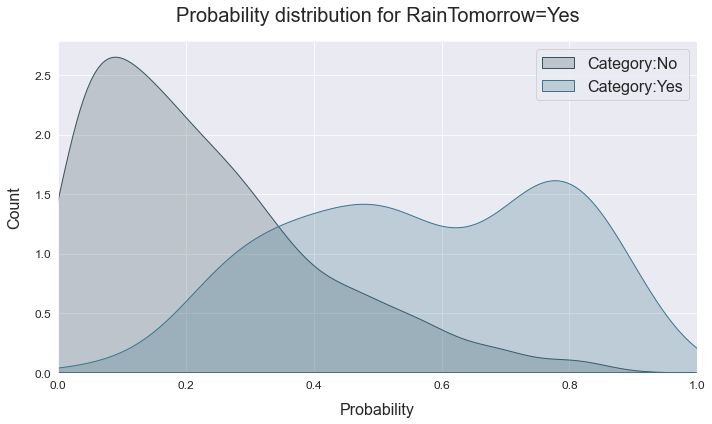

In [9]:
# The probabilties plot shows the distribution of predicted
# probabilities for the positive class
atom.winner.plot_probabilities()

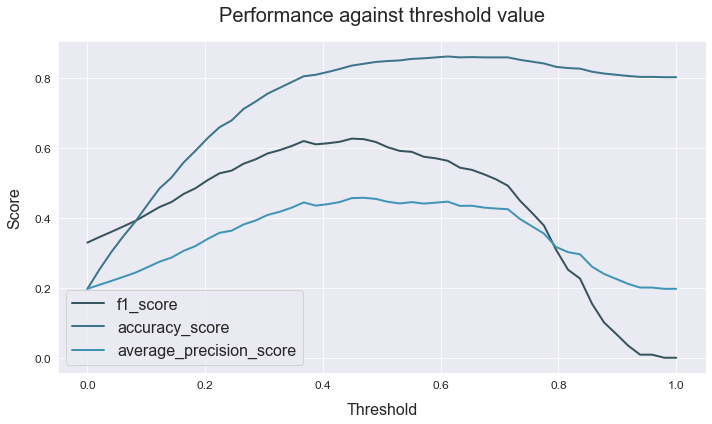

In [10]:
# The threshold plot let us compare how different metrics
# perform for different thresholds
atom.winner.plot_threshold(metric=['f1', 'accuracy', 'average_precision'], steps=50, filename='thresholds.png')

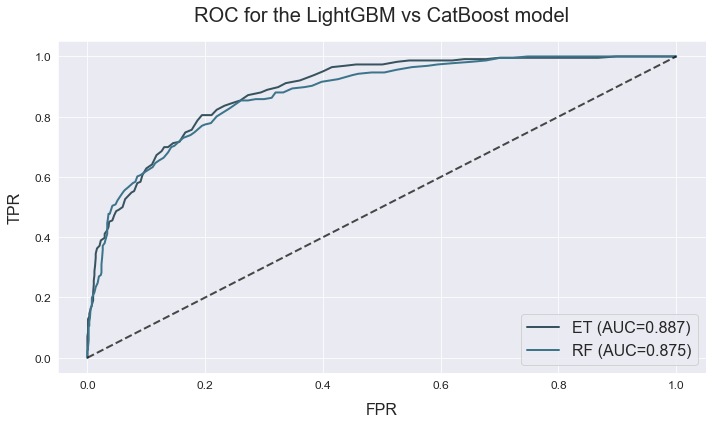

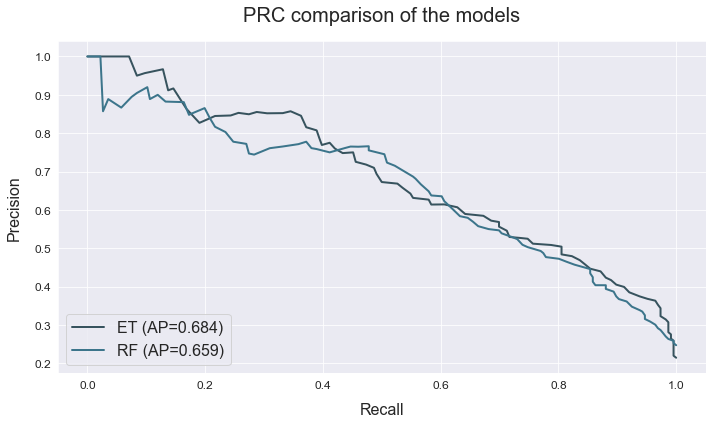

In [11]:
# The ROC and PRC curve are also typical ways of measuring performance 
atom.plot_roc(title="ROC for the LightGBM vs CatBoost model")
atom.plot_prc(title="PRC comparison of the models")